### Import packages

In [1]:
import sys
sys.path.insert(0,'../..')
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import torchattacks
import torchvision
from torchvision import transforms
from torchattacks.attack import Attack

### Import biotorch classes and functions

In [2]:
from biotorch.datasets.cifar import CIFAR10Benchmark
from biotorch.applications.adversarial_attacks.visualization import imshow, plot_accuracy
from biotorch.applications.adversarial_attacks.functions import add_data_normalization, apply_attack_on_dataset, apply_attack_on_batch 
from biotorch.layers.metrics import compute_matrix_angle

In [4]:
dataset = CIFAR10Benchmark(32, test_transforms=[
    transforms.transforms.Resize((32, 32)),
    transforms.ToTensor()])

cifar_mean = (0.4914, 0.4821, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

train_dataloader = dataset.create_train_dataloader(128)
val_dataloader = dataset.create_val_dataloader(128)
test_dataloader = dataset.create_test_dataloader(128)

Preparing CIFAR-10 Benchmark Dataset and storing data in ./datasets/cifar10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Define the models

In [5]:
trained_models_directory = '../trained_models/CIFAR10/resnet-20'

bp_model_path   = os.path.join(trained_models_directory, 'bp/model_best_acc.pth')
fa_model_path   = os.path.join(trained_models_directory, 'fa/model_best_acc.pth')
dfa_model_path  = os.path.join(trained_models_directory, 'dfa/model_best_acc.pth')
sign_usf_model_path = os.path.join(trained_models_directory, 'sign_usf/model_best_acc.pth')
sign_frsf_model_path = os.path.join(trained_models_directory, 'sign_frsf/model_best_acc.pth')
sign_brsf_model_path = os.path.join(trained_models_directory, 'sign_brsf/model_best_acc.pth')

In [6]:
model_bp = torch.load(bp_model_path, map_location='cuda:0')
model_bp = add_data_normalization(model_bp, cifar_mean, cifar_std).eval()

model_fa = torch.load(fa_model_path, map_location='cuda:0')
model_fa = add_data_normalization(model_fa, cifar_mean, cifar_std).eval()

model_dfa = torch.load(dfa_model_path, map_location='cuda:0')
model_dfa = add_data_normalization(model_dfa, cifar_mean, cifar_std).eval()

model_sign_usf = torch.load(sign_usf_model_path, map_location='cuda:0')
model_sign_usf = add_data_normalization(model_sign_usf, cifar_mean, cifar_std).eval()

model_sign_frsf = torch.load(sign_frsf_model_path, map_location='cuda:0')
model_sign_frsf = add_data_normalization(model_sign_frsf, cifar_mean, cifar_std).eval()

model_sign_brsf = torch.load(sign_brsf_model_path, map_location='cuda:0')
model_sign_brsf = add_data_normalization(model_sign_brsf, cifar_mean, cifar_std).eval()


In [6]:
class FGSM(Attack):
    r"""
    FGSM in the paper 'Explaining and harnessing adversarial examples'
    [https://arxiv.org/abs/1412.6572]
    Distance Measure : Linf
    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 0.007)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.FGSM(model, eps=0.007)
        >>> adv_images = attack(images, labels)
    """
    def __init__(self, model, eps=0.35, mode='bp'):
        super().__init__("FGSM", model)
        self.eps = eps
        self._supported_mode = ['default', 'targeted']
        self.mode=mode

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        loss_function = nn.CrossEntropyLoss()

        images.requires_grad = True
        
        outputs = self.model(images)
       
        # Calculate loss
        cost = loss_function(outputs, labels)
        
        if self.mode == 'DFA':
            # Zero gradients
            self.model.zero_grad()
            loss_gradient = torch.autograd.grad(cost, outputs, retain_graph=True)[0]
            # Broadcast gradient of the loss to every layer
            for layer in self.model[1].module.modules():
                layer.loss_gradient = loss_gradient
            
            cost.backward()
            grad = images.grad
        
        else:
            # Update adversarial images
            grad = torch.autograd.grad(cost, images, retain_graph=False, create_graph=False)[0]
        # save the gradient w.r.t. the input for further inspection
        self.grad = grad
        adv_images = images + self.eps*grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

### Run the FGSM attack

In [8]:
epsilons = np.linspace(0., 0.1, num=30)

In [9]:
attack_bp = FGSM(model_bp)
model_bp = model_bp.to(device)
clean_accuracy_bp, robust_accuracy_bp = apply_attack_on_dataset(model_bp, test_dataloader, 
                                                                attack_bp, epsilons, device, verbose=False)

Clean accuracy:  0.9061511


In [10]:
attack_fa = FGSM(model_fa)
model_fa = model_fa.to(device)
clean_accuracy_fa, robust_accuracy_fa = apply_attack_on_dataset(model_fa, test_dataloader, 
                                                                attack_fa, epsilons, device, verbose=False)

Clean accuracy:  0.6367682


In [11]:
attack_dfa = FGSM(model_dfa, mode='DFA')
model_dfa = model_dfa.to(device)
clean_accuracy_dfa, robust_accuracy_dfa = apply_attack_on_dataset(model_dfa, test_dataloader, 
                                                                attack_dfa, epsilons, device, verbose=False)

/home/mohamed/workspace/biotorch/.venv/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Clean accuracy:  0.60591376


In [12]:
attack_sign_usf = FGSM(model_sign_usf)
model_sign_usf = model_sign_usf.to(device)
clean_accuracy_sign_usf, robust_accuracy_sign_usf = apply_attack_on_dataset(model_sign_usf, test_dataloader, 
                                                                attack_sign_usf, epsilons, device, verbose=False)

Clean accuracy:  0.8506725


In [13]:
attack_sign_frsf = FGSM(model_sign_frsf)
model_sign_frsf = model_sign_frsf.to(device)
clean_accuracy_sign_frsf, robust_accuracy_sign_frsf = apply_attack_on_dataset(model_sign_frsf, test_dataloader, 
                                                                attack_sign_frsf, epsilons, device, verbose=False)

Clean accuracy:  0.8316851


In [14]:
attack_sign_brsf = FGSM(model_sign_brsf)
model_sign_brsf = model_sign_brsf.to(device)
clean_accuracy_sign_brsf, robust_accuracy_sign_brsf = apply_attack_on_dataset(model_sign_brsf, test_dataloader, 
                                                                attack_sign_brsf, epsilons, device, verbose=False)

Clean accuracy:  0.85047466


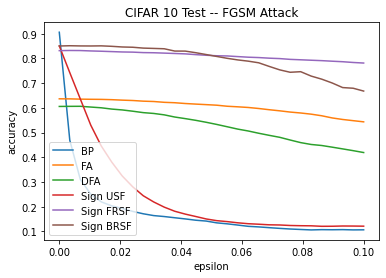

In [15]:
plot_accuracy(epsilons, 
              [
                  robust_accuracy_bp,
                  robust_accuracy_fa, 
                  robust_accuracy_dfa, 
                  robust_accuracy_sign_usf,
                  robust_accuracy_sign_frsf,
                  robust_accuracy_sign_brsf,
                            ], 
              ['BP', 'FA', 'DFA', 'Sign USF', 'Sign FRSF', 'Sign BRSF'],
              'CIFAR 10 Test -- FGSM Attack',
             'epsilon')

### Run the FGSM attack on a batch of the test set

In [16]:
test_dataloader = dataset.create_test_dataloader(128)

In [17]:
images, labels = iter(test_dataloader).next()

In [18]:
adv_images_fa, success_fa, accuracy_clean_fa, accuracy_robust_fa = apply_attack_on_batch(model_fa, images, labels, attack_fa, device)
plot_images_fa = images[success_fa]
plot_images_adv_fa = adv_images_fa[success_fa]

Clean Accuracy on Batch: 0.6796875%
Robust Accuracy on Batch: 0.6171875%


In [19]:
adv_images_bp, success_bp, accuracy_clean_bp, accuracy_robust_bp = apply_attack_on_batch(model_bp, images, labels, attack_bp, device)
plot_images_bp = images[success_bp]
plot_images_adv_bp = adv_images_bp[success_bp]

Clean Accuracy on Batch: 0.890625%
Robust Accuracy on Batch: 0.125%


In [20]:
adv_images_sign_usf, success_sign_usf, accuracy_clean_sign_usf, accuracy_robust_sign_usf = \
    apply_attack_on_batch(model_sign_usf, images, labels, attack_sign_usf, device)
plot_images_sign_usf = images[success_sign_usf]
plot_images_adv_sign_usf = adv_images_sign_usf[success_sign_usf]

Clean Accuracy on Batch: 0.859375%
Robust Accuracy on Batch: 0.140625%


In [21]:
adv_images_sign_brsf, success_sign_brsf, accuracy_clean_sign_brsf, accuracy_robust_sign_brsf = \
    apply_attack_on_batch(model_sign_brsf, images, labels, attack_sign_brsf, device)
plot_images_sign_brsf = images[success_sign_brsf]
plot_images_adv_sign_brsf = adv_images_sign_brsf[success_sign_brsf]

Clean Accuracy on Batch: 0.8828125%
Robust Accuracy on Batch: 0.734375%


In [22]:
adv_images_sign_frsf, success_sign_frsf, accuracy_clean_sign_frsf, accuracy_robust_sign_frsf = \
    apply_attack_on_batch(model_sign_frsf, images, labels, attack_sign_frsf, device)
plot_images_sign_frsf = images[success_sign_frsf]
plot_images_adv_sign_frsf = adv_images_sign_frsf[success_sign_frsf]

Clean Accuracy on Batch: 0.8203125%
Robust Accuracy on Batch: 0.1875%


In [23]:
adv_images_dfa, success_dfa, accuracy_clean_dfa, accuracy_robust_dfa = apply_attack_on_batch(model_dfa, images, labels, attack_dfa, device)
plot_images_dfa = images[success_dfa]
plot_images_adv_dfa = adv_images_dfa[success_dfa]

Clean Accuracy on Batch: 0.609375%
Robust Accuracy on Batch: 0.4453125%


/home/mohamed/workspace/biotorch/.venv/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


### Plot the adversarial images

In [24]:
n_adv = 64

#### BP

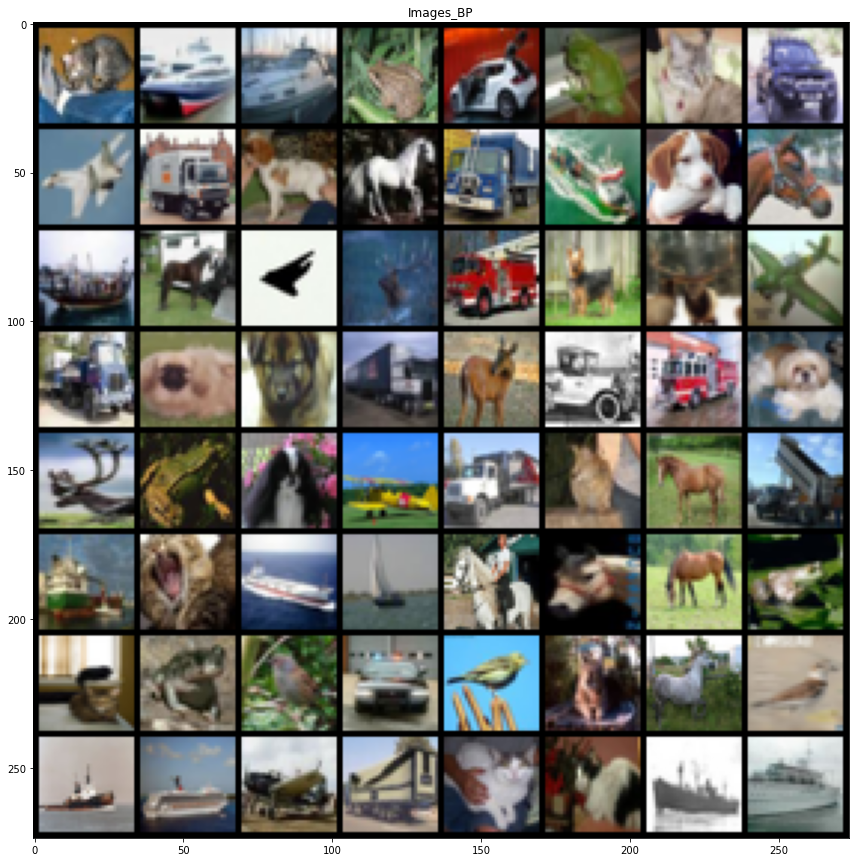

In [25]:
imshow(torchvision.utils.make_grid(plot_images_bp[0:n_adv], normalize=False), "Images_BP")

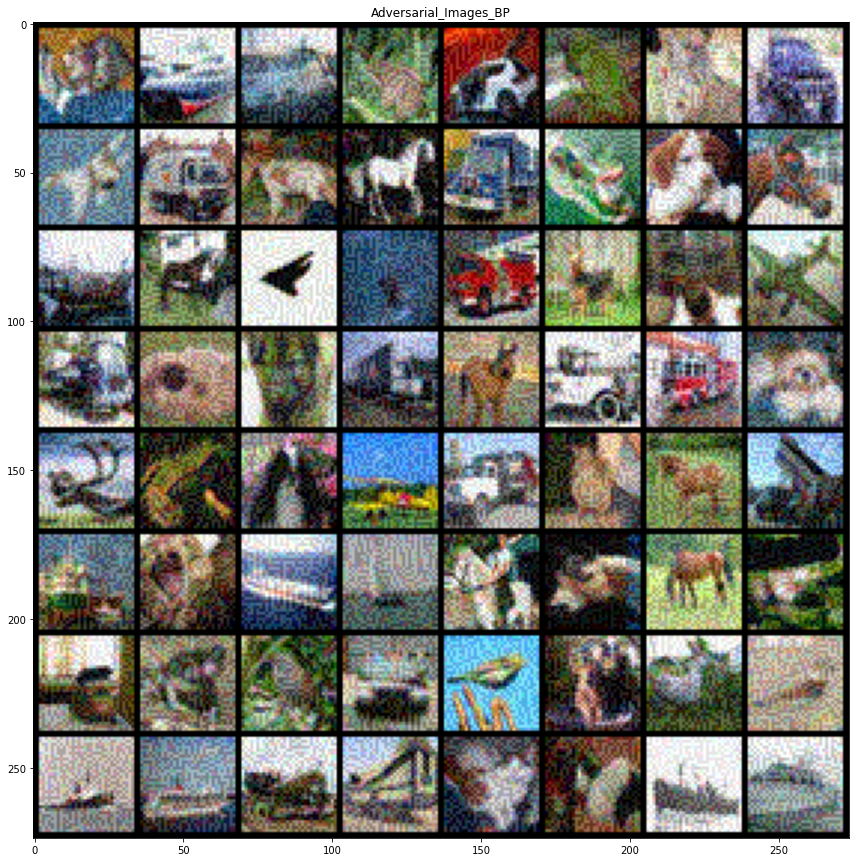

In [26]:
imshow(torchvision.utils.make_grid(plot_images_adv_bp[0:n_adv], normalize=False), "Adversarial_Images_BP")

#### FA

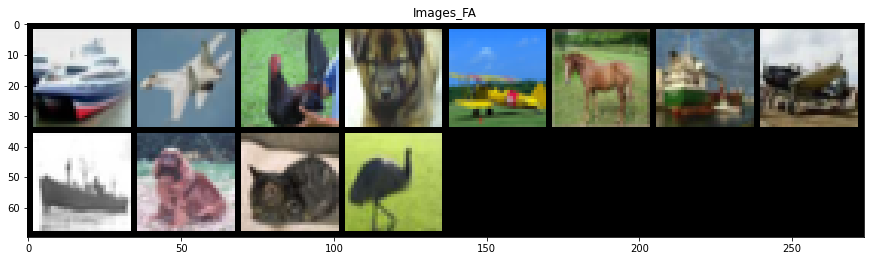

In [27]:
imshow(torchvision.utils.make_grid(plot_images_fa[0:n_adv], normalize=False), "Images_FA")

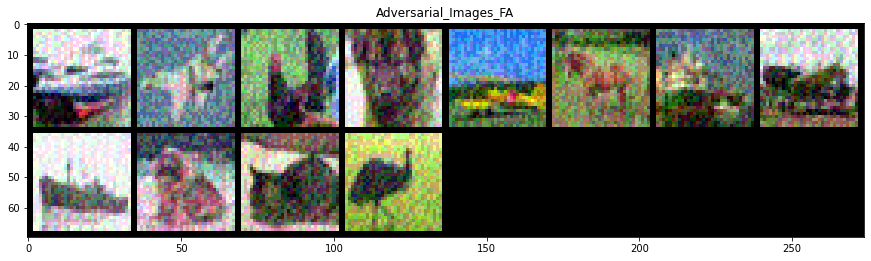

In [28]:
imshow(torchvision.utils.make_grid(plot_images_adv_fa[0:n_adv], normalize=False), "Adversarial_Images_FA")

#### DFA

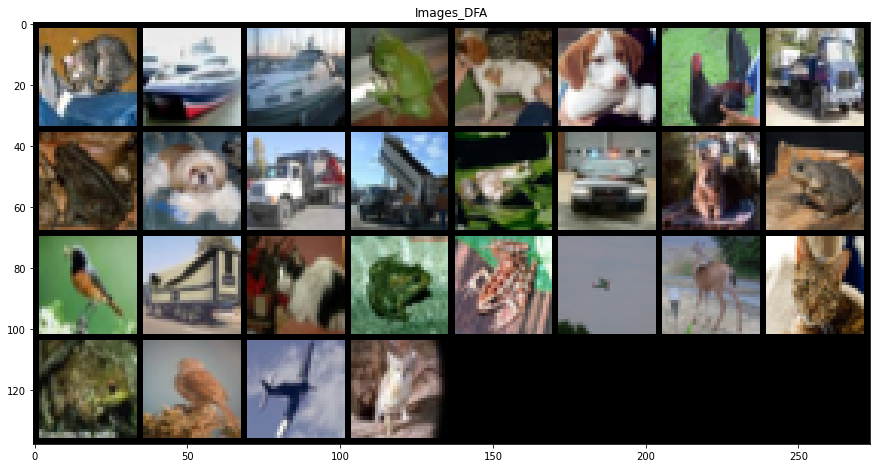

In [29]:
imshow(torchvision.utils.make_grid(plot_images_dfa[0:n_adv], normalize=False), "Images_DFA")

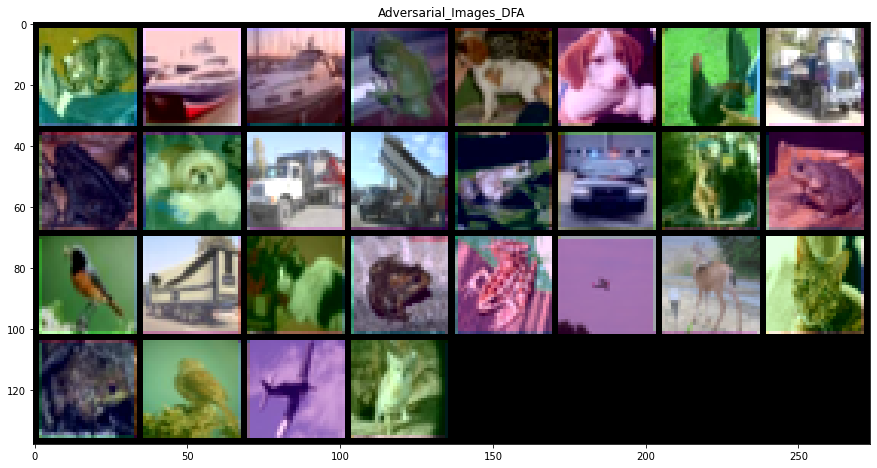

In [30]:
imshow(torchvision.utils.make_grid(plot_images_adv_dfa[0:n_adv], normalize=False), "Adversarial_Images_DFA")

#### Sign USF

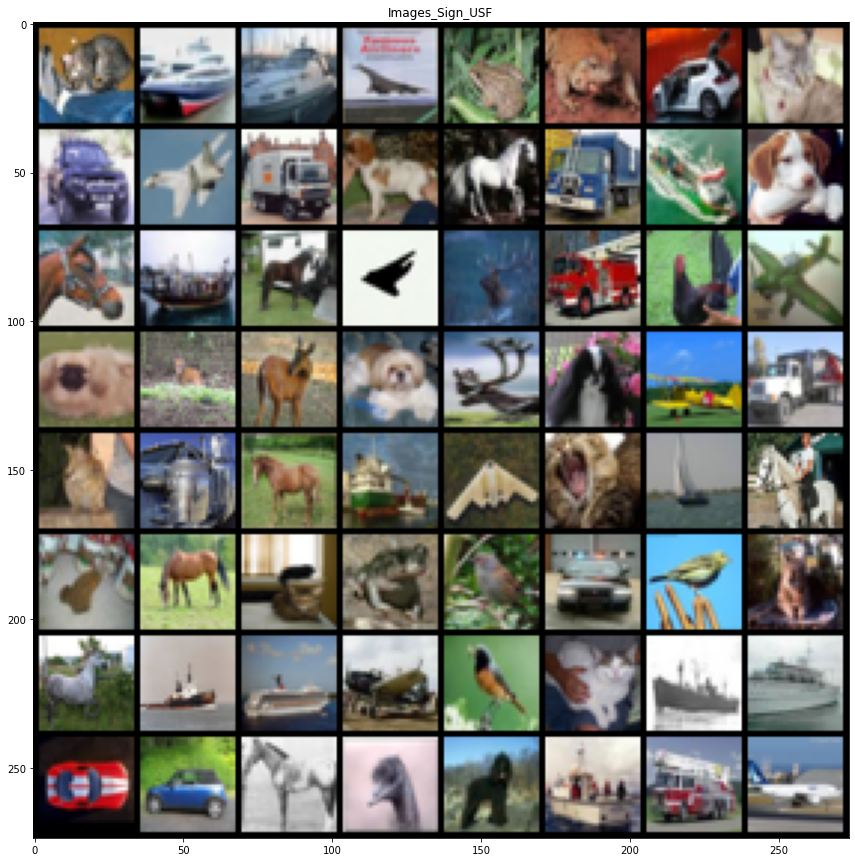

In [31]:
imshow(torchvision.utils.make_grid(plot_images_sign_usf[0:n_adv], normalize=False), "Images_Sign_USF")

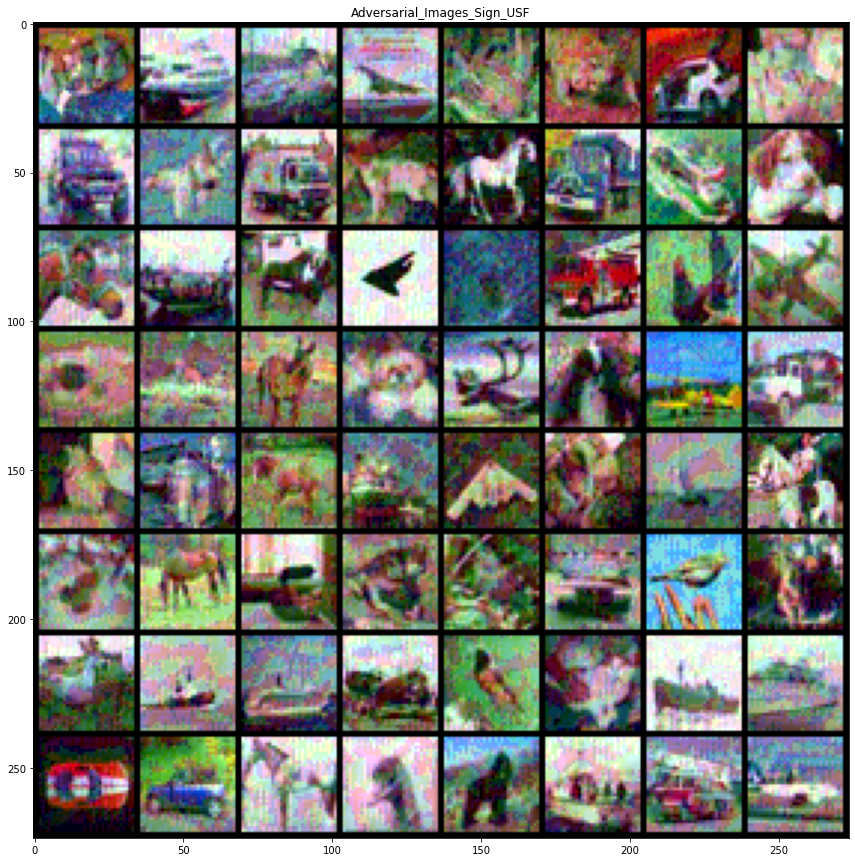

In [32]:
imshow(torchvision.utils.make_grid(plot_images_adv_sign_usf[0:n_adv], normalize=False), "Adversarial_Images_Sign_USF")

#### Sign BRSF

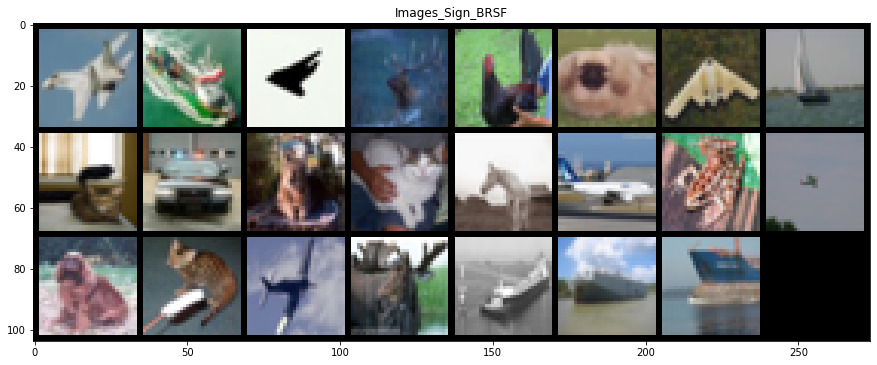

In [33]:
imshow(torchvision.utils.make_grid(plot_images_sign_brsf[0:n_adv], normalize=False), "Images_Sign_BRSF")

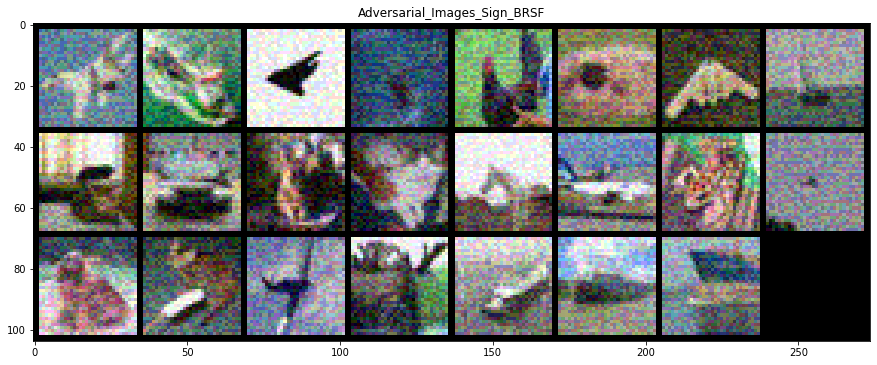

In [34]:
imshow(torchvision.utils.make_grid(plot_images_adv_sign_brsf[0:n_adv], normalize=False), "Adversarial_Images_Sign_BRSF")

#### Sign FRSF

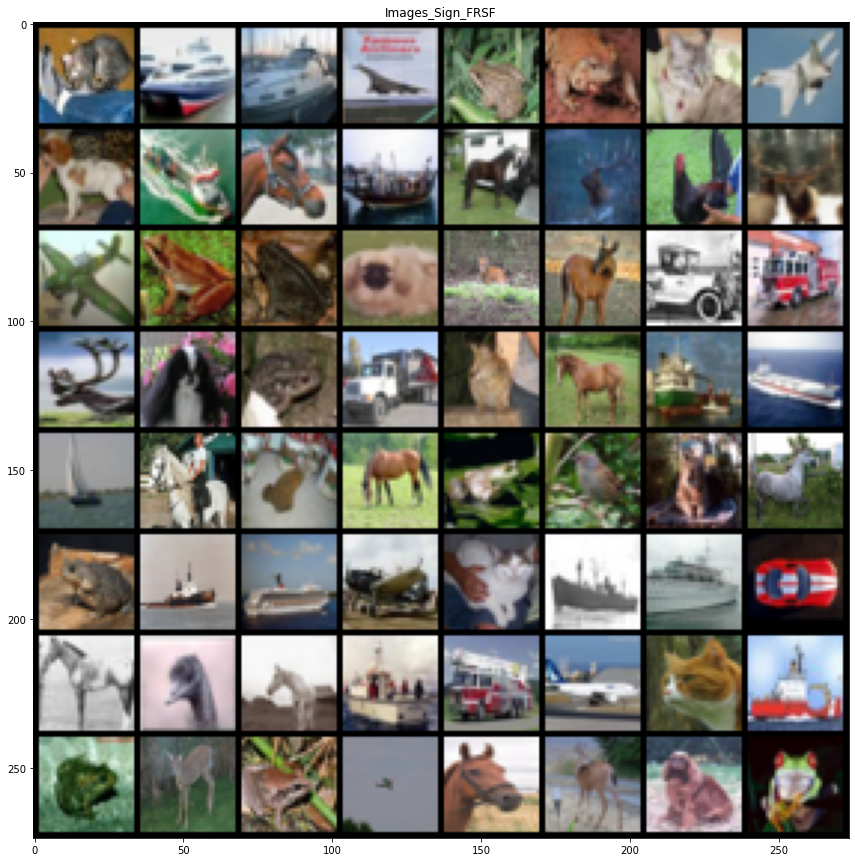

In [35]:
imshow(torchvision.utils.make_grid(plot_images_sign_frsf[0:n_adv], normalize=False), "Images_Sign_FRSF")

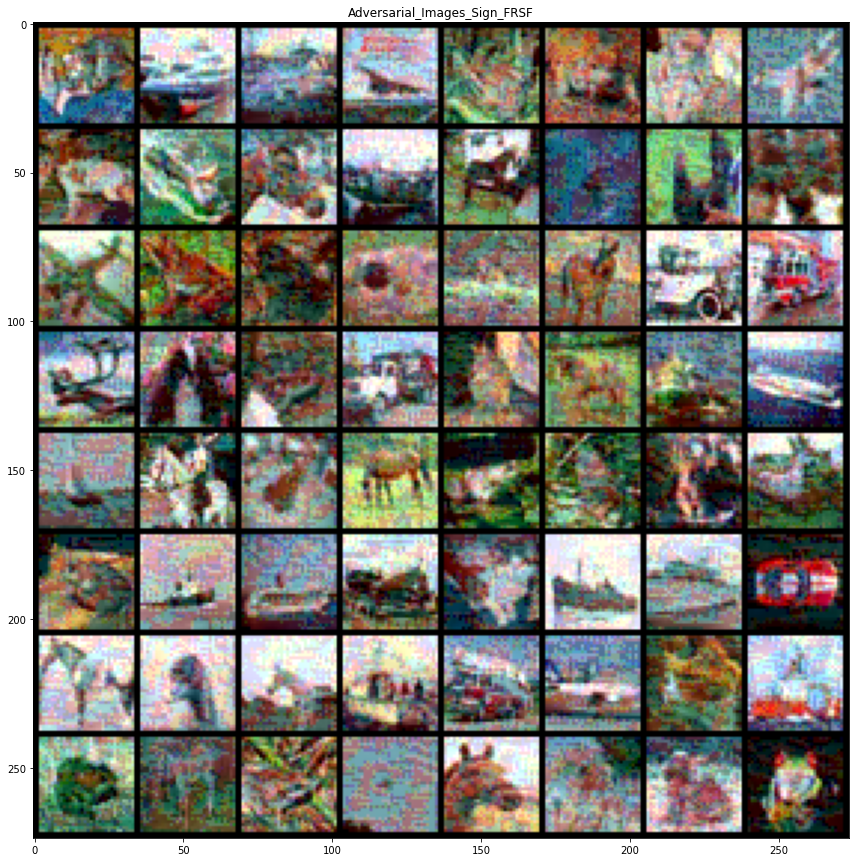

In [36]:
imshow(torchvision.utils.make_grid(plot_images_adv_sign_frsf[0:n_adv], normalize=False), "Adversarial_Images_Sign_FRSF")

### Compare the FGSM gradient w.r.t. the input

In [37]:
batch_id = 30
grad_bp = torch.flatten(attack_bp.grad[batch_id]).detach().cpu()
grad_fa = torch.flatten(attack_fa.grad[batch_id]).detach().cpu()
grad_dfa = torch.flatten(attack_dfa.grad[batch_id]).detach().cpu()
grad_sign_usf = torch.flatten(attack_sign_usf.grad[batch_id]).detach().cpu()
grad_sign_brsf = torch.flatten(attack_sign_brsf.grad[batch_id]).detach().cpu()
grad_sign_frsf = torch.flatten(attack_sign_frsf.grad[batch_id]).detach().cpu()

In [38]:
angle_bp_fa = compute_matrix_angle(grad_bp, grad_fa)
angle_bp_dfa = compute_matrix_angle(grad_bp, grad_dfa)
angle_bp_sign_usf = compute_matrix_angle(grad_bp, grad_sign_usf)
angle_bp_sign_brsf = compute_matrix_angle(grad_bp, grad_sign_brsf)
angle_bp_sign_frsf = compute_matrix_angle(grad_bp, grad_sign_frsf)
print("Angle w.r.t. BP:\nFA = {}, DFA = {}, Sign USF = {}, Sign BRSF = {}, Sign FRSF = {}".format(angle_bp_fa, angle_bp_dfa, angle_bp_sign_usf, angle_bp_sign_brsf, angle_bp_sign_frsf))

Angle w.r.t. BP:
FA = 89.35193634033203, DFA = 88.82490539550781, Sign USF = 86.43626403808594, Sign BRSF = 90.24337005615234, Sign FRSF = 86.96026611328125


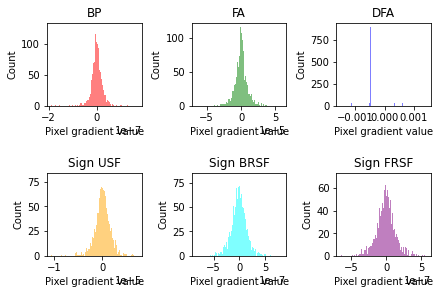

In [39]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(grad_bp.numpy(), bins = 256, color = 'red', alpha = 0.5)
axs[0, 0].set_title('BP')
axs[0, 1].hist(grad_fa.numpy(), bins = 256, color = 'Green', alpha = 0.5)
axs[0, 1].set_title('FA')
axs[0, 2].hist(grad_dfa.numpy(), bins = 256, color = 'Blue', alpha = 0.5)
axs[0, 2].set_title('DFA')
axs[1, 0].hist(grad_sign_usf.numpy(), bins = 256, color = 'Orange', alpha = 0.5)
axs[1, 0].set_title('Sign USF')
axs[1, 1].hist(grad_sign_brsf.numpy(), bins = 256, color = 'Cyan', alpha = 0.5)
axs[1, 1].set_title('Sign BRSF')
axs[1, 2].hist(grad_sign_frsf.numpy(), bins = 256, color = 'Purple', alpha = 0.5)
axs[1, 2].set_title('Sign FRSF')
for ax in axs.flat:
    ax.set(xlabel='Pixel gradient value', ylabel='Count')
fig.tight_layout(pad=0.4, w_pad=1.0, h_pad=2.0)